In [1]:
import os, sys, rdflib
from sklearn import metrics
import numpy as np, pandas as pd
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from SPARQLWrapper import SPARQLWrapper, JSON
import rdflib.plugins.sparql as sparql, matplotlib.pyplot as plt
sys.path.append(os.path.abspath("./util"))
from misc import *

plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
%%time
%store -r mid2types
if "mid2types" not in locals():
    dbpedia_type_graph = rdflib.Graph()
    dbpedia_type_graph.parse('./dataset/instance_types_en_uris_it.nt', format="nt" )
    dbpedia_type_graph.parse('./dataset/instance_types_en.nt', format="nt" )

CPU times: user 77 ms, sys: 12 ms, total: 89.1 ms
Wall time: 102 ms


In [3]:
%%time
# mapping freebase's mids to dbpedia's resources
mid2dbpedia = dict()
file_path = "./dataset/Release/freebase_code_names.txt"
with open(file_path, "r") as mapping_file:
    for line in mapping_file:
        mid, dbp_resource = line.replace("\n", "").split("\t")
        val = mid2dbpedia.get(mid, [])
        mid2dbpedia[mid] = val + [dbp_resource]

CPU times: user 278 ms, sys: 14.1 ms, total: 292 ms
Wall time: 320 ms


In [4]:
walks_path = "./dataset/Release/ttl/embedding_5_7_train.ttl.txt"

vocab_sequences = get_sequences(walks_path)
train_sequences = get_sequences(walks_path)

model = Word2Vec(min_count=1, window=5, negative=5, size=100)

model.build_vocab(vocab_sequences)
model.train(train_sequences)

418031

In [5]:
%%time
%store -r mid2types
if "mid2types" not in locals():
    mid2types = dict()
    for uri in model.vocab:
        mid = uri.replace("http://rdf.freebase.com/ns", "")
        if mid in mid2dbpedia:
            dbpedia_eqs = [uri[1:-1] for uri in mid2dbpedia[mid]]
            mid_types = {row[0].n3() for uri in dbpedia_eqs for row in get_types(uri, dbpedia_type_graph)}
            if len(mid_types) > 0:
                mid2types[mid] = mid_types
    %store mid2types

CPU times: user 227 µs, sys: 43 µs, total: 270 µs
Wall time: 251 µs


In [8]:
mid_prefix = "http://rdf.freebase.com/ns"

embeds = np.asarray([model[mid_prefix + mid] for mid in mid2types])
mids   = np.asarray([mid for mid in mid2types])
labels = get_ground_truth(mids, mid2types) # np.asarray([1 if is_person(mid, mid2types) else 0 for mid in mid2types])

random_idx = np.random.choice(range(len(embeds)), len(embeds), replace=False)
split_point = len(embeds) * 70 / 100
training_idx, test_idx = random_idx[:split_point], random_idx[split_point:]

embeds_train, embeds_test = embeds[training_idx], embeds[test_idx]
mids_train,   mids_test   = mids[training_idx], mids[test_idx]
labels_train, labels_test = labels[training_idx], labels[test_idx]

tsne = TSNE(n_components=2)
%store -r twodims
if "twodims" not in locals():
    twodims = tsne.fit_transform(embeds)
    %store twodims

ground_truth = get_ground_truth(mids, mid2types)

colors = [get_color(i) for i in ground_truth]

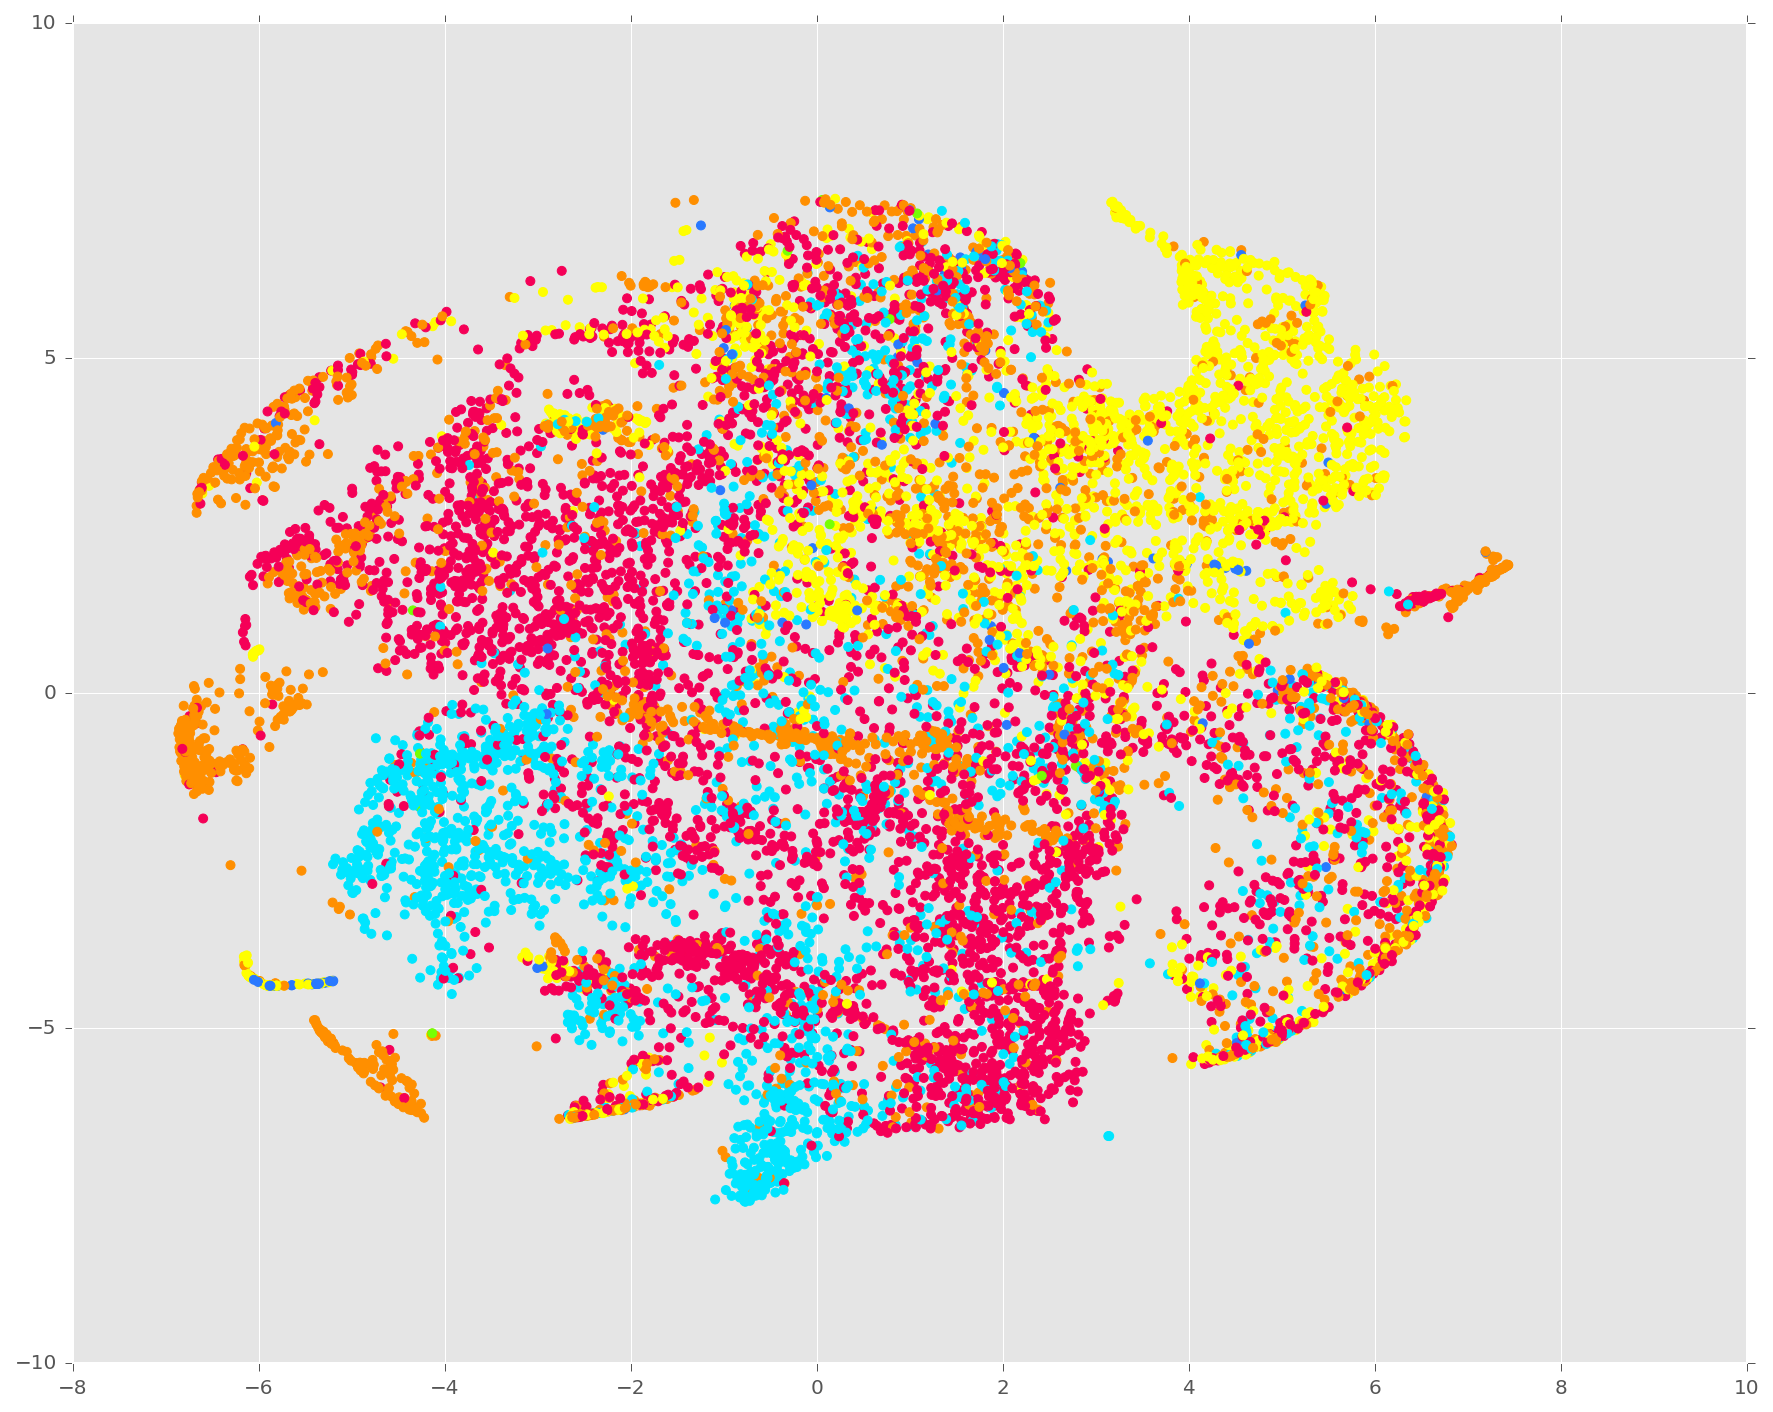

In [10]:
fig_size = [15, 12]
plt.rcParams["figure.figsize"] = fig_size
x = [point[0] for point in twodims]
y = [point[1] for point in twodims]
plt.scatter(x, y, color=colors)
plt.show()

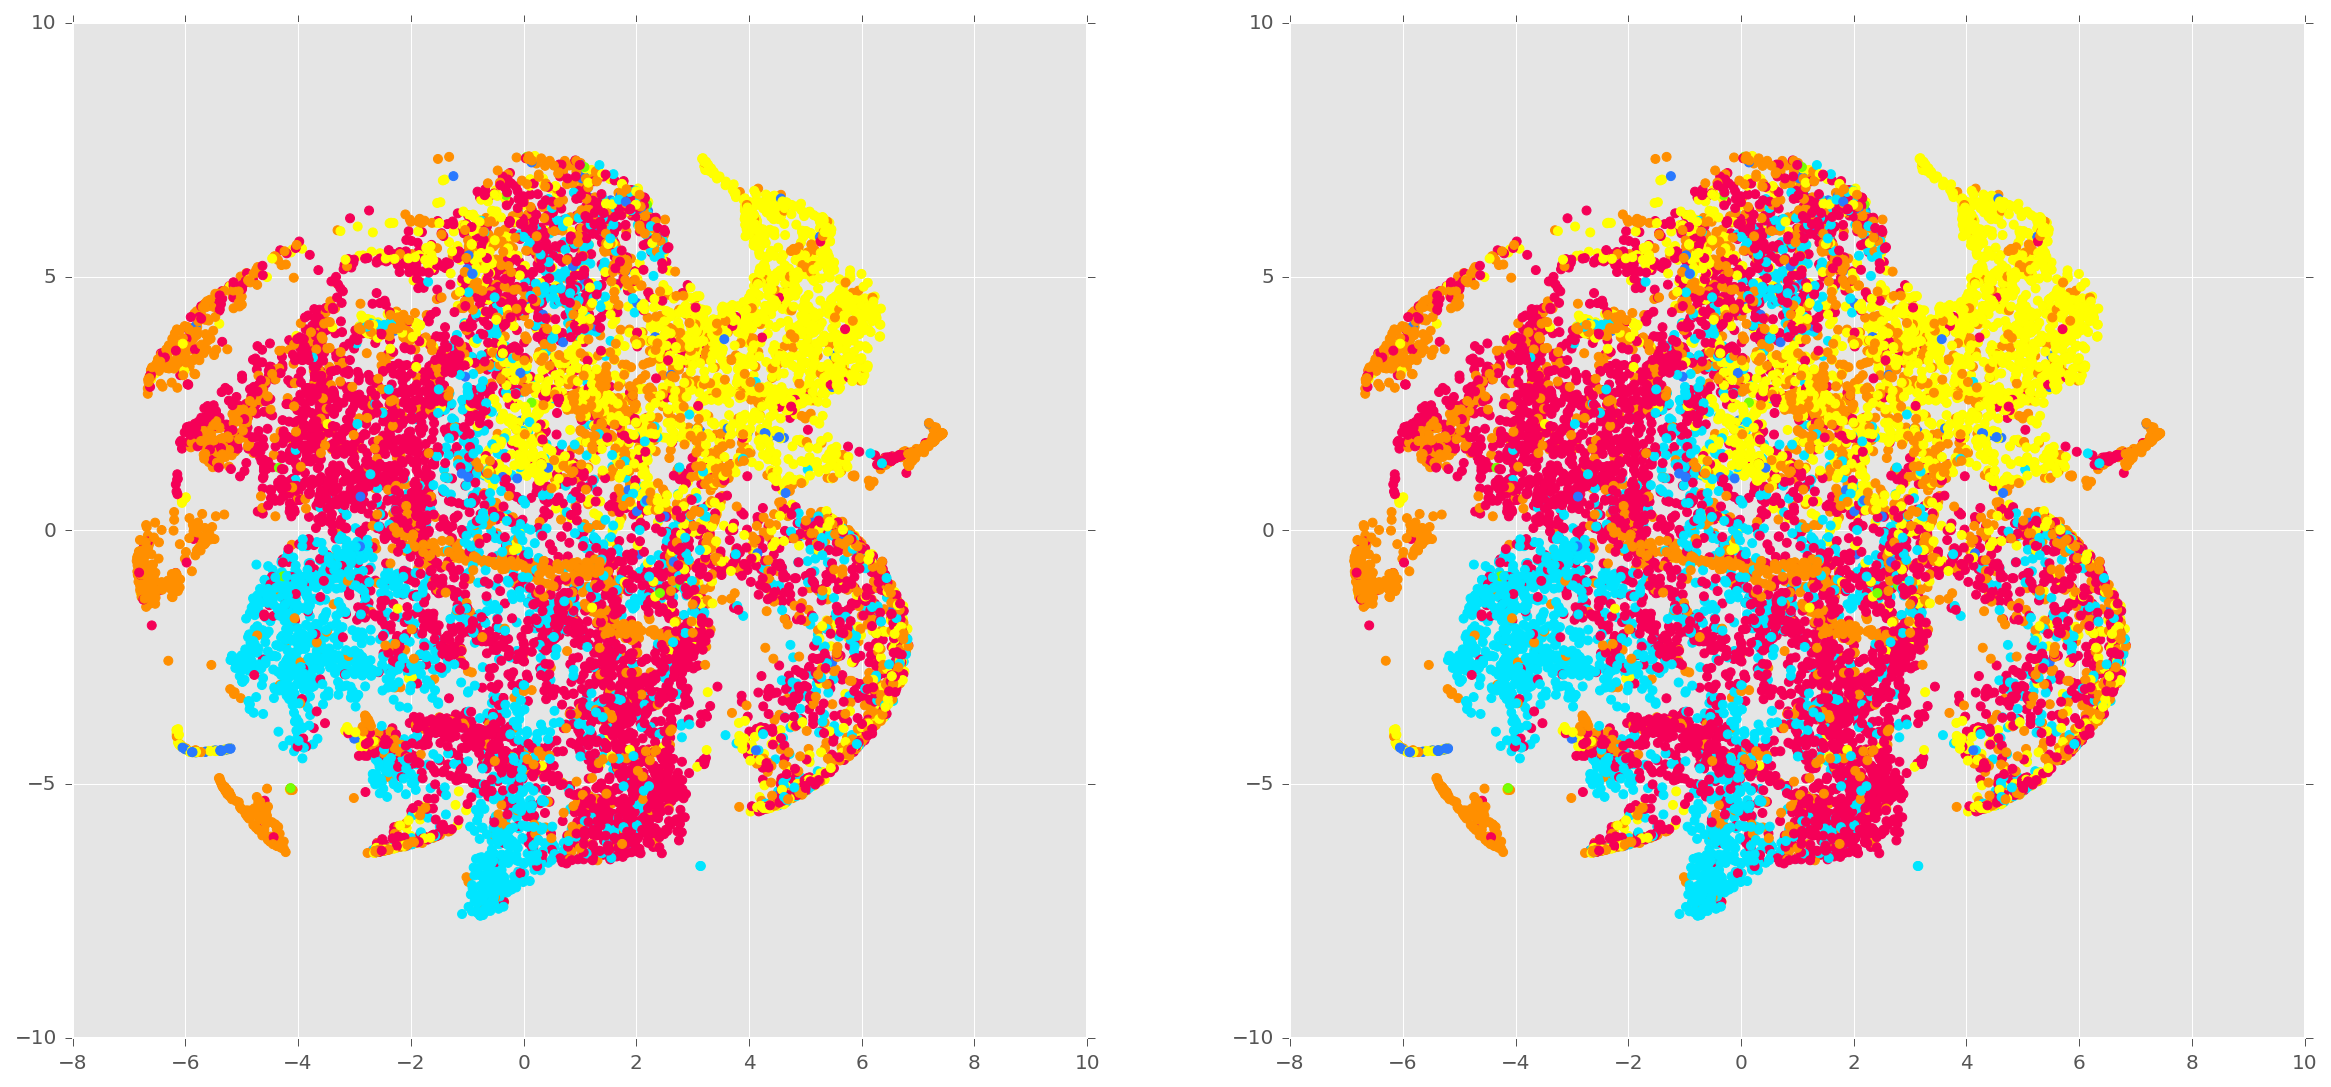

In [12]:
fig_size = [20, 20]
plt.rcParams["figure.figsize"] = fig_size

fig, ax = plt.subplots(nrows=1,ncols=2)
plt.subplot(2, 2, 1)
plt.scatter(x, y, color=colors)

plt.subplot(2, 2, 2)
plt.scatter(x, y, color=colors)
plt.show()